# 1.Data Exploration:

In [13]:
%pip install datasets
from datasets import load_dataset

# Load the dataset
dataset = load_dataset('yelp_review_full')

Note: you may need to restart the kernel to use updated packages.


In [14]:
print(dataset)
print(dataset['train'][:5])
df = dataset['train'].to_pandas()
print(df.head())

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})
{'label': [4, 1, 3, 3, 0], 'text': ["dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.", "Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It u

The dataset has 650,000 training samples and 50,000 testing samples. Each sample has a 'label' and some 'text'. The 'label' is a number from 0 to 4 that means 1 start to 5 stars and shows how good or bad the review is. The 'text' is the review itself. The next step in the code will create a picture that shows how many samples there are for each label number, both for training and testing. This is to make sure we have a fair mix, which helps build fair and reliable machine learning models.

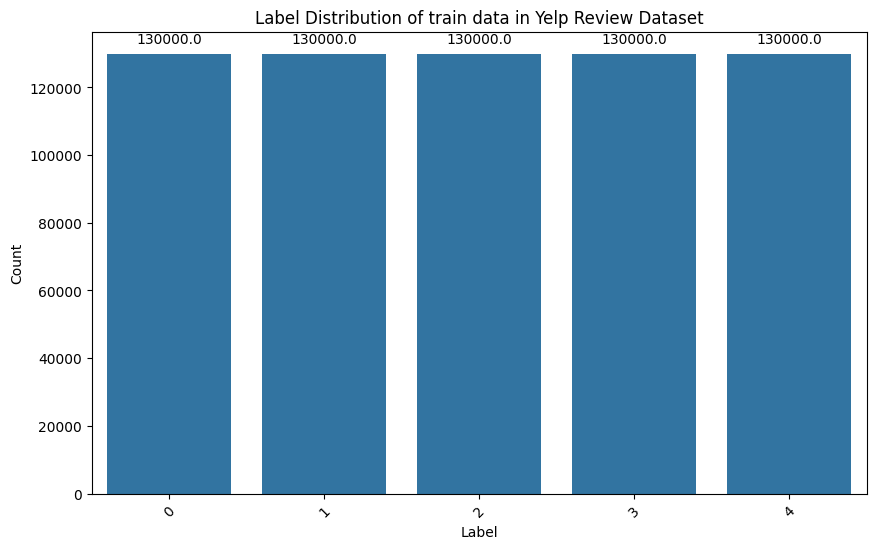

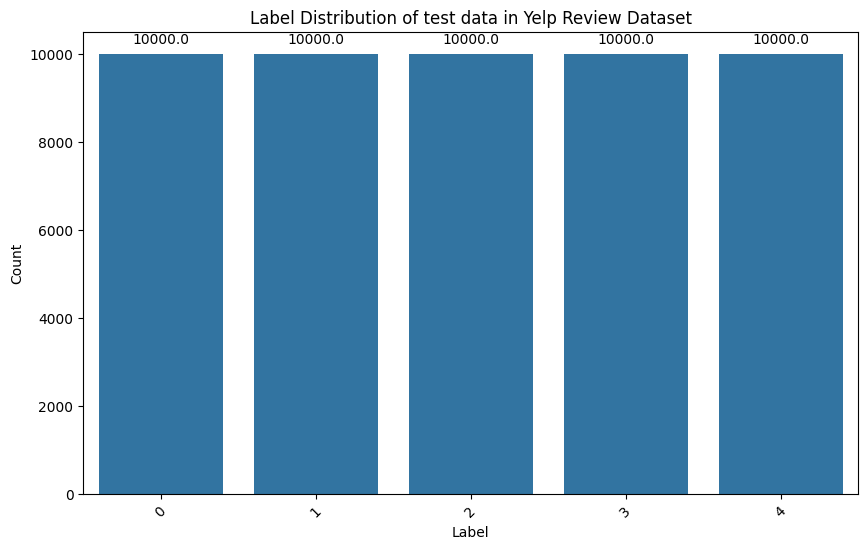

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot the distribution of labels
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='label')
plt.title('Label Distribution of train data in Yelp Review Dataset')
plt.xlabel('Label')
plt.ylabel('Count')

# Annotate each bar with the count of observations
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

plt.xticks(rotation=45)
plt.show()

df_test = dataset['test'].to_pandas()
# Plot the distribution of labels
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_test, x='label')
plt.title('Label Distribution of test data in Yelp Review Dataset')
plt.xlabel('Label')
plt.ylabel('Count')

# Annotate each bar with the count of observations
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

plt.xticks(rotation=45)
plt.show()

The two images depict the label distributions in the training and test datasets, respectively. Each chart shows an equal count for all labels, which is crucial for developing unbiased machine learning models with broad applicability. This uniformity ensures that the models trained on this data can learn and evaluate effectively without preference for any particular label.

# 2. Sentiment Analysis:

# 3. Classification Tasks: Zero Shot Classification
## 3.a. Based on Summary

In [16]:
from transformers import pipeline
from datasets import load_dataset
import pandas as pd
import torch

# Create a text summarization pipeline using the BART model
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Initialize an empty list to store summaries
summaries = []

# Dynamically adjust max_length and summarize the text
for text in df['text'].iloc[:150].tolist():
    input_length = len(text.split())  # Estimate the number of words in the input
    max_length = min(130, max(30, int(input_length * 0.5)))  # Dynamically adjust max_length
    summary = summarizer(text, max_length=max_length, min_length=30, truncation=True)[0]['summary_text']
    summaries.append(summary)

# Create a new dataframe to store the original texts and their summaries
# Make sure to also copy the star rating information, assuming in the original dataset the star rating is stored in the 'label' column
df_summary = df.iloc[:150].copy()  # Copy the first 150 rows
df_summary['summary'] = summaries  # Add the summaries to the new dataframe
df_summary['stars'] = df['label'].iloc[:150]  # Copy the corresponding star ratings

print(df_summary[['text', 'summary', 'stars']])

Your max_length is set to 30, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 30, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)
Your max_length is set to 30, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)
Your max_length is set to 30, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_leng

                                                  text  \
0    dr. goldberg offers everything i look for in a...   
1    Unfortunately, the frustration of being Dr. Go...   
2    Been going to Dr. Goldberg for over 10 years. ...   
3    Got a letter in the mail last week that said D...   
4    I don't know what Dr. Goldberg was like before...   
..                                                 ...   
145  Even when we didn't have a car Filene's Baseme...   
146  Love this store!  Don't always have much luck ...   
147  Another store which has gone the way of the Do...   
148  $9.75 for a red bull and vodka? I'm sorry, I t...   
149  Really enjoyed this a lot more than I thought ...   

                                               summary  stars  
0     dr. goldberg offers everything i look for in ...      4  
1    The frustration of being Dr. Goldberg's patien...      1  
2    I've been going to Dr. Goldberg for over 10 ye...      3  
3    Dr. Goldberg is moving to Arizona to take 

Data Preparation

In [19]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

class YelpReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels   # Convert labels from 1-5 to 0-4

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Prepare the data
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
X = df_summary['summary'].tolist()  # Summary texts
y = df_summary['stars'].to_numpy()  # Star ratings

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2021)

train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=512)

train_dataset = YelpReviewDataset(train_encodings, y_train)
val_dataset = YelpReviewDataset(val_encodings, y_val)


Model Definition, Training and Evaluation.

In [20]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()
trainer.evaluate()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Yue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
  0%|          | 0/45 [24:05<?, ?it/s]
                                      
  0%|          | 0/45 [18:57<?

{'loss': 1.653, 'grad_norm': 5.85977840423584, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.67}


                                      
  0%|          | 0/45 [19:48<?, ?it/s]         

{'loss': 1.6375, 'grad_norm': 6.079554080963135, 'learning_rate': 2.0000000000000003e-06, 'epoch': 1.33}


                                      
  0%|          | 0/45 [20:38<?, ?it/s]         

{'loss': 1.6171, 'grad_norm': 4.7647199630737305, 'learning_rate': 3e-06, 'epoch': 2.0}


                                      
  0%|          | 0/45 [21:27<?, ?it/s]         

{'loss': 1.6226, 'grad_norm': 6.65775728225708, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.67}


                                      
100%|██████████| 45/45 [03:43<00:00,  4.97s/it]


{'train_runtime': 223.4901, 'train_samples_per_second': 1.611, 'train_steps_per_second': 0.201, 'train_loss': 1.6244254642062717, 'epoch': 3.0}


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


{'eval_loss': 1.6399976015090942,
 'eval_runtime': 4.3772,
 'eval_samples_per_second': 6.854,
 'eval_steps_per_second': 0.914,
 'epoch': 3.0}


### Result List
5   'train_loss': 1.1762760480244954 'eval_loss': 1.5997843742370605

15  'train_loss': 1.3541520436604817 'eval_loss': 0.7361515164375305

30  'train_loss': 1.2990621990627713 'eval_loss': 1.175505518913269

100 'train_loss': 1.2386985460917155 'eval_loss': 1.1782324314117432

150 'train_loss': 1.1339557965596516 'eval_loss': 1.2087987661361694

The second result in the list shows an intriguing case where the evaluation loss is significantly lower than the training loss. This is an unusual scenario in machine learning models because typically, the training loss is lower due to the model being directly trained on that data. Here, an eval_loss of 0.736 compared to a train_loss of 1.354 suggests a few possible scenarios:

Strong Generalization: The model may generalize exceptionally well to the validation data, possibly because the validation set characteristics closely match the model's training data, or the model has learned robust features that work well across varied data samples.

Data Distribution: The distribution of data in the training set might be more challenging or diverse compared to the evaluation set, which can lead to higher training loss.

Evaluation Set Size: If the evaluation set is significantly smaller or not as diverse, it might not represent the difficulty of the overall dataset, leading to a deceptively low evaluation loss.

Overfitting Avoidance: It's also possible that certain regularization techniques or early stopping mechanisms were effective in preventing the model from overfitting, hence the model performs better on unseen data.

Random Variation: Especially with smaller datasets, random variation can sometimes lead to situations where evaluation loss is lower than training loss.

### The number 300 is used to specify the number of text entries from the Yelp review dataset that we want to process.

1.Data Selection: df['text'].iloc[:300].tolist() – This line selects the first 300 entries from the 'text' column of the dataframe df. The .iloc[:300] is an indexing operation used in pandas to select data by position. Here, it slices the first 300 rows of the dataframe.

2.Summarization Process: The loop for text in df['text'].iloc[:300].tolist() iterates over each of the first 300 text entries. For each text, the script estimates the input length, adjusts the maximum summary length accordingly, and then generates a summary using the BART model.

### Ideal Range

Close to 0 but not 0: Ideally, the loss value should be close to 0, which indicates that the model's predictions are very close to the actual labels. However, a loss value of 0 might suggest that the model is overfitting on the training set, perfectly memorizing the training data, which could lead to poor performance on unseen data.

Eval loss close to train loss: If the evaluation loss (eval_loss) and training loss (train_loss) are very close, it is usually a good sign, indicating that the model performs consistently on both the training and validation sets, demonstrating good generalization ability.

### Specific Range

Loss value: The specific range of loss values greatly depends on the characteristics of the dataset and the complexity of the model. For some tasks, such as simple classification problems, the loss value might be between 0.01 and 0.5. For more complex tasks or more challenging datasets, the loss value might range from 1 to 10, or even higher.

Difference: The difference between the training loss and evaluation loss should be as small as possible. A good rule of thumb is that the difference should not exceed 10% to 20% of the training loss. For example, if the train_loss is 0.5, the eval_loss should ideally be between 0.5 and 0.6.

### Loss Values in Our Model

Training Loss (train_loss) of 1.1339557965596516: This indicates the average degree of error the model has when recognizing patterns in the training data. For a complex NLP task, this value might be considered reasonable in the initial stages, especially considering the use of a large pre-trained model and a complex dataset.

Evaluation Loss (eval_loss) of 1.2087987661361694: This is slightly higher than the training loss. Such a scenario is common in machine learning models, as the evaluation loss represents the model's performance on unseen data, which is usually slightly higher than the training loss.

### Judging Whether Loss Values are "High" or "Low"

Generally, for text classification tasks, if both training and evaluation losses are below 1.0, this is usually considered good performance. However, even if loss values are between 1.0 and 2.0, this may still be acceptable performance depending on the task's complexity and the characteristics of the dataset.

It's important to monitor how loss values change with training progress. Ideally, you would want to see both training and evaluation losses gradually decrease as the number of epochs increases, and the gap between them should not significantly widen over time, as this may indicate overfitting.

## 3.b. Zero-Shot Classification

In [ ]:
#randly select 100 samples
df = df.sample(100)
print(df)

In [21]:
import pandas as pd
# Manually add categories to each review and import the dataset
df = pd.read_csv('yelp_review_full.csv')
# Define categories
classes = ["Restaurants", "Bars", "Coffee Shops", "Hotels", "Salons/Barbershops",
           "Auto Repair", "Home Services", "Medical Services", "Entertainment", "Pet Services",
           "Financial Services", "Travel & Tourism", "Education", "Real Estate", "Fitness",
           "Landscaping & Gardening Services", "Legal Services", "Photography Services",
           "Childcare Services", "Computer & Technology Services"]

Model process

In [22]:
from transformers import pipeline

# Model 1: facebook/bart-large-mnli
classifier_1 = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
def model1_review(text):
    result = classifier_1(text, candidate_labels=classes, multi_label=True)
    return result['labels'][0]  # Returning the top category

# Apply the function to each review in the DataFrame
df['model1'] = df['text'].apply(model1_review)
print(df.head())

   label                                               text  \
0      4  I've been going here for about 4 yrs.Cleanest ...   
1      1  We've wanted to try Thai E-San since they open...   
2      0  The food is ok but the service is terrible!!!!...   
3      3  There's typically a 15-20 minute wait when we ...   
4      3  Five guys offers a basic selection of burgers,...   

      Manual_Category         model1  
0  Salons/Barbershops  Entertainment  
1         Restaurants    Restaurants  
2         Restaurants    Restaurants  
3         Restaurants    Restaurants  
4         Restaurants    Restaurants  


In [23]:
# Model 2: knowledgator/comprehend_it-multilingual-t5-base
# pip install liqfit sentencepiece
from liqfit.pipeline import ZeroShotClassificationPipeline
from liqfit.models import T5ForZeroShotClassification
from transformers import T5Tokenizer

model = T5ForZeroShotClassification.from_pretrained('knowledgator/comprehend_it-multilingual-t5-base')
tokenizer = T5Tokenizer.from_pretrained('knowledgator/comprehend_it-multilingual-t5-base')
classifier_2 = ZeroShotClassificationPipeline(model=model, tokenizer=tokenizer,
                                                      hypothesis_template = '{}', encoder_decoder = True)
def model2_review(text):
    result = classifier_2(text, candidate_labels=classes, multi_label=True)
    return result['labels'][0]  # Returning the top category

# Apply the function to each review in the DataFrame
df['model2'] = df['text'].apply(model2_review)
print(df.head())

You are using a model of type T5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


   label                                               text  \
0      4  I've been going here for about 4 yrs.Cleanest ...   
1      1  We've wanted to try Thai E-San since they open...   
2      0  The food is ok but the service is terrible!!!!...   
3      3  There's typically a 15-20 minute wait when we ...   
4      3  Five guys offers a basic selection of burgers,...   

      Manual_Category         model1         model2  
0  Salons/Barbershops  Entertainment  Home Services  
1         Restaurants    Restaurants   Pet Services  
2         Restaurants    Restaurants    Restaurants  
3         Restaurants    Restaurants    Restaurants  
4         Restaurants    Restaurants    Restaurants  


In [24]:
# Model 3: MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli
# pip install transformers[sentencepiece]
from transformers import pipeline
classifier_3 = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli")
def model3_review(text):
    result = classifier_3(text, candidate_labels=classes, multi_label=True)
    return result['labels'][0]  # Returning the top category

# Apply the function to each review in the DataFrame
df['model3'] = df['text'].apply(model3_review)
print(df.head())

C:\Users\Yue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Yue\.cache\huggingface\hub\models--MoritzLaurer--DeBERTa-v3-base-mnli-fever-anli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDebertaV2ForSequenceClassification: ['deberta.embeddings.position_ids']
- This IS expected if you are initializing TFDebertaV2ForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDebertaV2ForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDebertaV2ForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2ForSequenceClassification for predictions without further training.
Asking to truncate to max_length but no maximum length is provided and 

   label                                               text  \
0      4  I've been going here for about 4 yrs.Cleanest ...   
1      1  We've wanted to try Thai E-San since they open...   
2      0  The food is ok but the service is terrible!!!!...   
3      3  There's typically a 15-20 minute wait when we ...   
4      3  Five guys offers a basic selection of burgers,...   

      Manual_Category         model1         model2              model3  
0  Salons/Barbershops  Entertainment  Home Services  Salons/Barbershops  
1         Restaurants    Restaurants   Pet Services         Restaurants  
2         Restaurants    Restaurants    Restaurants         Restaurants  
3         Restaurants    Restaurants    Restaurants         Restaurants  
4         Restaurants    Restaurants    Restaurants         Restaurants  


Comparison and Accuracy Calculation:

In [25]:
accuracy1 = (df['model1'] == df['Manual_Category']).mean()
accuracy2 = (df['model2'] == df['Manual_Category']).mean()
accuracy3 = (df['model3'] == df['Manual_Category']).mean()
print("Accuracy of model 1: ", accuracy1)
print("Accuracy of model 2: ", accuracy2)
print("Accuracy of model 3: ", accuracy3)

Accuracy of model 1:  0.61
Accuracy of model 2:  0.59
Accuracy of model 3:  0.73


### Model 1: facebook/bart-large-mnli
Accuracy: 61%

This model uses a combined bidirectional encoder and autoregressive decoder, trained on the MNLI dataset. Its moderate accuracy suggests that while effective at general language tasks, it may not fully capture the specific nuances of Yelp reviews.

### Model 2: knowledgator/comprehend_it-multilingual-t5-base
Accuracy: 59%

Based on the T5 architecture, which processes tasks as text generation in multiple languages, its slightly lower performance might stem from its generalist training which is not specialized enough for the particular characteristics of Yelp reviews.

### Model 3: MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli
Accuracy: 73%

DeBERTa enhances BERT architectures with a novel attention mechanism and is further fine-tuned on datasets aimed at improving inference, resulting in the highest accuracy among the three models. This suggests superior handling of the complex semantics in review texts.


In summary, the varying accuracies reflect each model’s architectural strengths and training focus, with DeBERTa standing out due to its advanced inference capabilities and specialized attention mechanism.